In [1]:
cd ..

/home/cody/inner-knowledge-pruning


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import torch
import copy
import glob
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report

from src.dataloader import make_data_loader
from src.model_loader import load_model
from src.trainers import first_eval, class_report
from src.analytics import fix_state_dict, df_builder

## Setup 

create student and teacher models. Load them onto device.
gather teacher predictions over validation set.

In [4]:
dataloaders, dataset_sizes = make_data_loader(8, 'imagenette')
student, teacher = load_model('models/baseline/imagenette/vgg16.pt', 'imagenette', 'vgg16')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

student = student.to(device)
teacher = teacher.to(device)

ground_labels, teacher_pred = class_report(teacher, dataloaders, dataset_sizes)
_, student_pred = class_report(student, dataloaders, dataset_sizes)

class_names = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]

report = classification_report(ground_labels, teacher_pred, target_names=class_names, output_dict=True)


Make PIE and classification report DF builder

In [6]:
dfs = df_builder(ground_labels, teacher_pred)

run model statistics over population for PIE and accuracy and ad them to data frame 

In [7]:
mag_30 = glob.glob('models/imagenette/vgg16/struct_mag/lr_0.0005/alpha_1.0/sparsity_0.3/*.pt') 
mag_45 = glob.glob('models/imagenette/vgg16/struct_mag/lr_0.0005/alpha_1.0/sparsity_0.45/*.pt')
mag_60 = glob.glob('models/imagenette/vgg16/struct_mag/lr_0.0005/alpha_1.0/sparsity_0.6/*.pt')
mag_75 = glob.glob('models/imagenette/vgg16/struct_mag/lr_0.0005/alpha_1.0/sparsity_0.75/*.pt')
mag_90 = glob.glob('models/imagenette/vgg16/struct_mag/lr_0.0005/alpha_1.0/sparsity_0.9/*.pt')

models = [(mag_30, 30), (mag_45, 45), (mag_60, 60), (mag_75, 75), (mag_90, 90)]

for (paths, sparsity) in models:

    dfs.add_models(paths=paths, sparsity=sparsity, method='Struct Mag', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/inner-knowledge-pruning/src/analytics.py:98: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [8]:
ik_30 = glob.glob('models/imagenette/vgg16/ik_struct_mag/lr_0.0005/alpha_0.01/sparsity_0.3/*.pt')
ik_45 = glob.glob('models/imagenette/vgg16/ik_struct_mag/lr_0.0005/alpha_0.01/sparsity_0.45/*.pt')
ik_60 = glob.glob('models/imagenette/vgg16/ik_struct_mag/lr_0.0005/alpha_0.01/sparsity_0.6/*.pt')
ik_75 = glob.glob('models/imagenette/vgg16/ik_struct_mag/lr_0.0005/alpha_0.01/sparsity_0.75/*.pt')
ik_90 = glob.glob('models/imagenette/vgg16/ik_struct_mag/lr_0.0005/alpha_0.01/sparsity_0.9/*.pt')

models = [(ik_30, 30), (ik_45, 45), (ik_60, 60), (ik_75, 75), (ik_90, 90)]

for (paths, sparsity) in models:
    dfs.add_models(paths=paths, sparsity=sparsity, method='IK Struct Mag', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


In [9]:
dfs.PIEs

,PIEs,method,sparsity
0,100.0,Struct Mag,30.0
1,115.0,Struct Mag,45.0
2,105.0,Struct Mag,60.0
3,104.0,Struct Mag,75.0
4,85.0,Struct Mag,90.0
5,79.0,IK Struct Mag,30.0
6,65.0,IK Struct Mag,45.0
7,89.0,IK Struct Mag,60.0
8,74.0,IK Struct Mag,75.0
9,69.0,IK Struct Mag,90.0


In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
teacher_conf = confusion_matrix(ground_labels, teacher_pred)
student_conf = confusion_matrix(ground_labels, student_pred)

In [27]:
FP_t = teacher_conf.sum(axis=0) - np.diag(teacher_conf)
FN_t = teacher_conf.sum(axis=1) - np.diag(teacher_conf)
TP_t = np.diag(teacher_conf)
TN_t = teacher_conf.sum() - (FP_t + FN_t + TP_t)

FPR_t = FP_t / (FP_t  + TN_t)
FNR_t = FN_t / (FN_t + TP_t)

IK_Stats = dfs.pruning_stats[np.logical_and(dfs.pruning_stats.method == 'IK Struct Mag', dfs.pruning_stats.sparsity == 75)]

mean_FPR_IK = IK_Stats.FP_r.mean(axis=0)
mean_FNR_IK = IK_Stats.FN_r.mean(axis=0)
FPR_IK_change = (mean_FPR_IK - FPR_t)/FPR_t * 100
FPN_IK_change = (mean_FNR_IK - FNR_t)/FNR_t * 100
print(FPR_IK_change)
print(FPN_IK_change)

Struct_Stats = dfs.pruning_stats[np.logical_and(dfs.pruning_stats.method == 'Struct Mag', dfs.pruning_stats.sparsity == 75)]
mean_FPR_Struct = Struct_Stats.FP_r.mean(axis=0)
mean_FNR_Struct = Struct_Stats.FN_r.mean(axis=0)
FPR_Struct_change = (mean_FPR_Struct - FPR_t)/FPR_t * 100
FPN_Struct_change = (mean_FNR_Struct - FNR_t)/FNR_t * 100
print(FPR_Struct_change)
print(FPN_Struct_change)

[ 52.77777778 -10.9375     -11.2244898   -8.24175824 -10.71428571
   7.55813953  25.         -24.56140351 -20.65217391   4.31034483]
[-20.45454545  -2.94117647   4.62962963   6.52173913 -11.53846154
 -19.44444444 -28.125        6.0483871   -7.89473684  -0.67567568]
[119.44444444  25.          -5.10204082  18.13186813  15.17857143
  73.25581395  67.85714286 -16.66666667 -30.43478261  17.24137931]
[ 15.90909091   0.          42.59259259  48.36956522   7.69230769
 -13.88888889  -6.25        25.80645161  33.55263158   6.75675676]


In [28]:
%config InlineBackend.figure_format = 'retina'

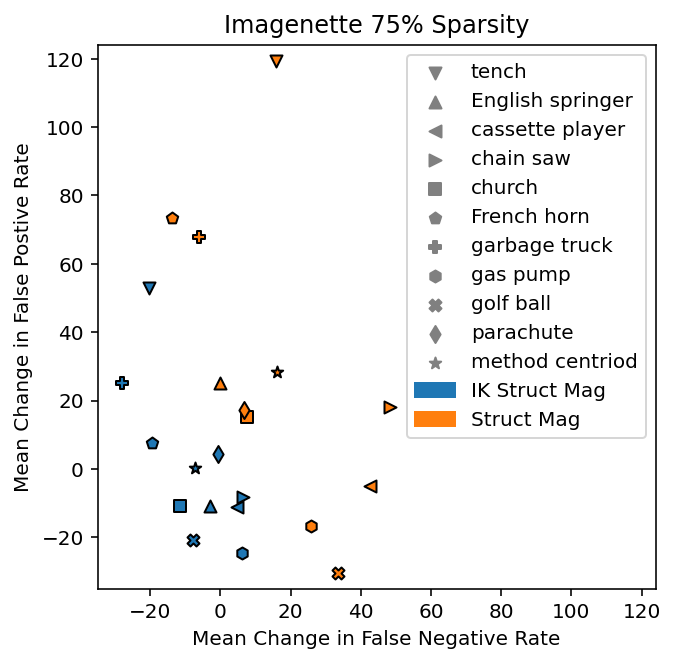

In [42]:
### FP Barchart

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import itertools

fig, ax = plt.subplots(figsize=(5,5))
m = ("v", "^", "<", ">", "s", "p", "P", "h", "X", "d", "*")
markers = itertools.cycle(m)

handles = []
plt.xlim(-35, 124)
plt.ylim(-35, 124)
for x, y in zip(FPN_IK_change, FPR_IK_change):
    handles.append(plt.scatter(x, y, marker=next(markers), c='#1f77b4', edgecolors='black'))
#plt.scatter(FPR_IK_change, FPN_IK_change)
handles.append(plt.scatter(np.mean(FPN_IK_change), np.mean(FPR_IK_change), marker=next(markers), c='#1f77b4', edgecolors='black'))
for x, y in zip(FPN_Struct_change, FPR_Struct_change):
    plt.scatter(x, y, marker=next(markers), c='#ff7f0e', edgecolors='black')
plt.scatter(np.mean(FPN_Struct_change), np.mean(FPR_Struct_change), marker=next(markers), c='#ff7f0e', edgecolors='black')
# plt.scatter(FPR_Struct_change, FPN_Struct_change)

handles.append(mpatches.Patch(color="#1f77b4", label='IK Struct Mag'))
handles.append(mpatches.Patch(color="#ff7f0e", label='Struct Mag'))
ax.legend(handles, class_names+['method centriod', 'IK Struct Mag', 'Struct Mag'])
leg = ax.get_legend()
for handle in leg.legendHandles[:-2]:
    handle.set_color('grey')
plt.xlabel('Mean Change in False Negative Rate')
plt.ylabel('Mean Change in False Postive Rate')
plt.title("Imagenette 75% Sparsity")
plt.show()


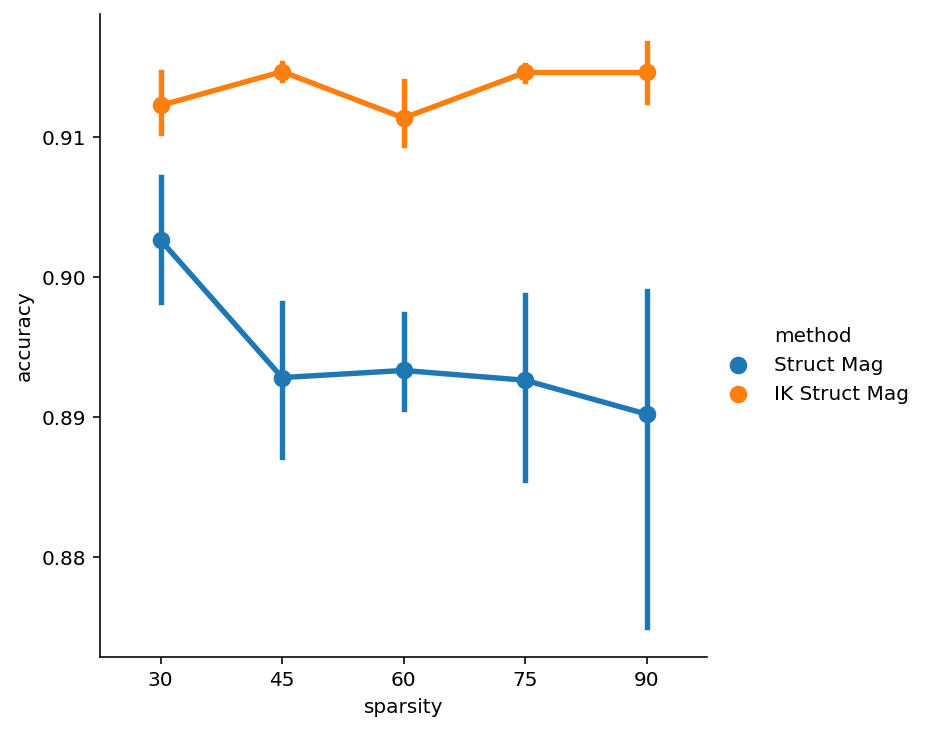

In [30]:
acc_plot = sns.catplot(x='sparsity', y='accuracy', hue='method', kind='point', data=dfs.pruning_stats)

acc_plot.savefig('figures/Acc_Struct_imagenette.jpg', dpi=600)
acc_plot.savefig('figures/Acc_Struct_imagenette.png', dpi=600)

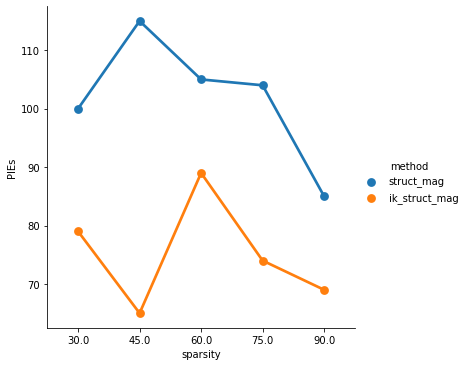

In [11]:
pie_fig = sns.catplot(x='sparsity', y='PIEs', hue='method', kind='point', data=dfs.PIEs)

pie_fig.savefig('figures/PIE_Struct_imagenette.jpg', dpi=600)
pie_fig.savefig('figures/PIE_Struct_imagenette.png', dpi=600)


In [12]:
sm, ik = dfs.pie_idx['struct_mag'][90], dfs.pie_idx['ik_struct_mag'][90]

In [13]:
ik_not_sm = np.nonzero(np.isin(ik, sm, invert=True))[0]
sm_not_ik = np.nonzero(np.isin(sm, ik, invert=True))[0]
inter = np.intersect1d(ik, sm)
print(f'finegrain PIES: {sm.size}')
print(f'ik PIES: {ik.size}')
print(f'# in fg not in ik: {sm_not_ik.size}')
print(f'# in ik not in fg: {ik_not_sm.size}')
print(f'intersection : {inter.size}')


finegrain PIES: 85
ik PIES: 69
# in fg not in ik: 54
# in ik not in fg: 38
intersection : 31


In [14]:
inter_ds = make_data_loader(1, dataset='imagenette', subset=inter)
ik_ds = make_data_loader(1, dataset='imagenette', subset=ik)
sm_ds = make_data_loader(1, dataset='imagenette', subset=sm)

In [15]:
ground_labels_inter, teacher_pred_inter = class_report(teacher, inter_ds[0], inter_ds[1])
report_inter = classification_report(ground_labels_inter, 
                                     teacher_pred_inter, 
                                     target_names=class_names, 
                                     output_dict=True)

ground_labels_ik, teacher_pred_ik = class_report(teacher, ik_ds[0], ik_ds[1])
report_ik = classification_report(ground_labels_ik, 
                                     teacher_pred_ik, 
                                     target_names=class_names, 
                                     output_dict=True)

ground_labels_sm, teacher_pred_sm = class_report(teacher, sm_ds[0], sm_ds[1])
report_sm = classification_report(ground_labels_sm, 
                                     teacher_pred_sm, 
                                     target_names=class_names, 
                                     output_dict=True)

In [16]:
print(f'intersection accuracy {report_inter["accuracy"]}')
print(f'IK PIES accuracy {report_ik["accuracy"]}')
print(f'SM PIES accuracy {report_sm["accuracy"]}')

intersection accuracy 0.9085350318471338
IK PIES accuracy 0.9085350318471338
SM PIES accuracy 0.9085350318471338


In [17]:
dfs.pruning_stats

,accuracy,recall,f1-score,sparsity,method,full_report
0,0.896561,0.896716,0.897444,30,struct_mag,"{'tench': {'precision': 0.9648648648648649, 'r..."
1,0.909554,0.909912,0.909802,30,struct_mag,"{'tench': {'precision': 0.9554973821989529, 'r..."
2,0.904459,0.904731,0.905348,30,struct_mag,"{'tench': {'precision': 0.9623655913978495, 'r..."
3,0.899873,0.900430,0.900965,30,struct_mag,"{'tench': {'precision': 0.9549071618037135, 'r..."
4,0.899873,0.900206,0.900709,45,struct_mag,"{'tench': {'precision': 0.94750656167979, 'rec..."
5,0.892994,0.893306,0.893936,45,struct_mag,"{'tench': {'precision': 0.9453125, 'recall': 0..."
6,0.893248,0.893515,0.894219,45,struct_mag,"{'tench': {'precision': 0.9595687331536388, 'r..."
7,0.885096,0.885372,0.885210,45,struct_mag,"{'tench': {'precision': 0.9417989417989417, 'r..."
8,0.889936,0.890206,0.891297,60,struct_mag,"{'tench': {'precision': 0.9566395663956639, 'r..."
9,0.899363,0.899493,0.900150,60,struct_mag,"{'tench': {'precision': 0.9650537634408602, 'r..."


In [18]:
image, label = next(iter(inter_ds[0]['val']))

In [19]:
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from torch.nn import Upsample


In [20]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [21]:
show(image)

ValueError: axes don't match array

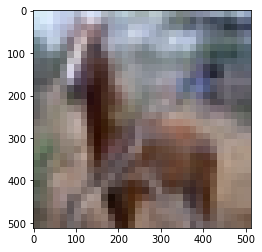

In [24]:
up = Upsample(scale_factor=16, mode='nearest')
for i, (image, label) in enumerate(inter_ds[0]['val']):
    show(make_grid(image, nrow=8, normalize=True))
    path = 'figures/PIE_images/'
    name = f'pie_{i}_{class_names[label]}_{class_names[int(teacher_pred_inter[i])]}.jpg'
    #save_image(image, normalize=True, fp=path+name)

In [25]:
teacher_pred_inter[0]

4.0